In [68]:
%matplotlib inline

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, FuncFormatter
import seaborn as sns

runs_dir = "runs-csv"

runs = {
    "task": [],
    "lr": [],
    "batch_size": [],
    "delay": [],
    "last_test_acc": [],
    "max_test_acc": []
}

for run_name in sorted(os.listdir(runs_dir)):
    task, lr, batch_size, delay = run_name.split("_")
    lr = float(lr)
    batch_size = int(batch_size)
    
    # not looking at batch sizes greater than 1024
    if batch_size > 1024:
        continue
    
    # discard learning rates that are not powers of 2
    if lr > 1 or not np.log2(lr).is_integer():
        continue
        
    # discard delays except 8
    delay = int(delay)
    if delay != 8:
        continue
    
    test_accs = []
    
    with open(os.path.join(runs_dir, run_name, "test_accuracy"), "r") as test_file:    
        for line in test_file:
            epoch, acc = line.split(",")
            epoch, acc = int(epoch), float(acc) / 100
            test_accs.append(acc)
        
    runs["task"].append(task)
    runs["lr"].append(lr)
    runs["batch_size"].append(batch_size)
    runs["delay"].append(delay)
    runs["last_test_acc"].append(test_accs[-1])
    runs["max_test_acc"].append(max(test_accs))

runs_df = pd.DataFrame.from_dict(runs)

In [69]:
def discrete_cmap(N, base_cmap=None, b=10):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.logspace(0, 1, N, base=b) / b)
#     color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

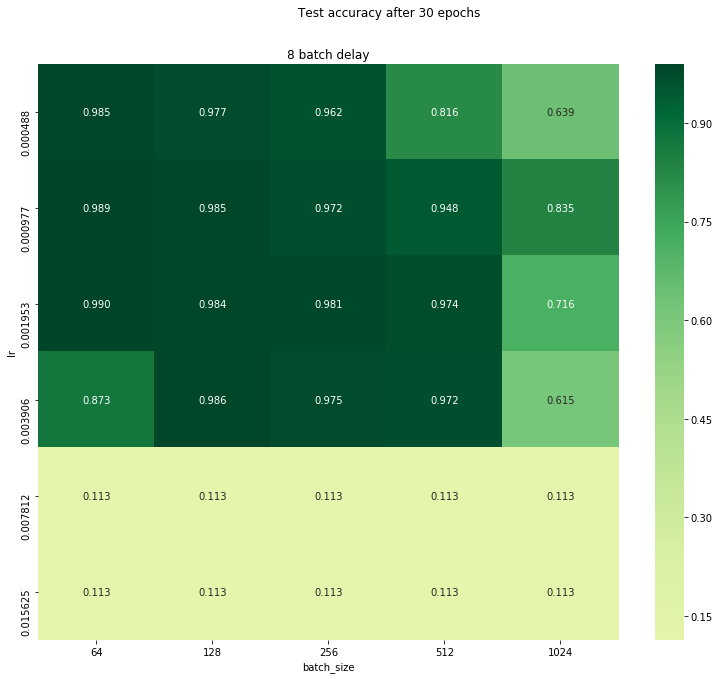

In [72]:
num_plots = len(runs_df.delay.unique())
fig, ax = plt.subplots(figsize=(num_plots * 13, 10), ncols=num_plots, nrows=1)
if not isinstance(ax, list):
    ax = [ax]
plt.suptitle("Test accuracy after 30 epochs")

left   =  0.125  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  0.1    # the amount of width reserved for blank space between subplots
hspace =  1.1    # the amount of height reserved for white space between subplots

# This function actually adjusts the sub plots using the above paramters
plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)

for (idx, delay) in enumerate(runs_df.delay.unique()):
    selected_df = runs_df[runs_df["delay"] == delay]
    selected_df["lr"] = selected_df["lr"].map(lambda lr: "{:.6f}".format(lr))

    pivoted = selected_df.pivot(index="lr", columns="batch_size", values="last_test_acc")
    
    ax[idx].set_title("{} batch delay".format(delay))
    sns.heatmap(pivoted, annot=True, cmap=discrete_cmap(999, "YlGn", 5), fmt=".3f", ax=ax[idx])
    if idx != 0:
        ax[idx].get_yaxis().set_visible(False)

# ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.6e}"))
# ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.6e}"))
# ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: print(y, _)))
# ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.6e}"))

plt.savefig("runs_heatmap.eps")

In [50]:
selected_df["lr"].dtype

dtype('O')